# DSCI 591: Data Science Capstone I <br> EDA on FLAME 1 Dataset

## Project Objective

1. Build model to detect the presence of forest fires
2. Build model to detect border / boundary of forest fire

## Primary Use Case

Park rangers pilot drones to at-risk locations for surveillance and early fire detection. Data is relayed as input for the model.

## Description of Data

1. **Primary Use:** Primary Modeling Dataset
2. **Summary:** Contains raw video and processed images from a controlled burn in an Arizon pine forest. Specifically, there are video recordings and thermal heatmaps (infrared cameras).
3. **Link:** https://paperswithcode.com/dataset/flame

## List of Files within Dataset

1. Raw Video (All)
        a. File Type: MP4
        b. Description: 966s footage from Zenmuse X4S camera
2. Raw Video (Specific Burn Patch)
        a. File Type: MP4
        b. Description: 400s footage from Zenmuse X4S camera
3. Raw Video (thermal - White Hot)
        a. File Type: MOV
        b. Description: 89s footage from FLIR Vue Pro R thermal camera     
4. Raw Video (thermal - Green Hot)
        a. File Type: MOV
        b. Description: 305s from FLIR Vue Pro R thermal camera
5. Raw Video (thermal fusion)
        a. File Type: MOV
        b. Description: 25-min footage from FLIR Vue Pro R thermal camera
6. Raw Video (Phantom Drone)
        a. File Type: MOV
        b. Description: 17-min footage from DJI Phantom 3 camera
7. Training / Validation Images (Classification)
        a. File Type: JPG
        b. Description: 39,375 frames, either “Fire” or “No Fire”
8. Test Images (Classification)
        a. File Type: JPG
        b. Description: 8,617 frames, either “FIre” or “No Fire”
9. Images (Segmentation)
        a. File Type: JPG
        b. Description: 2,003 frames for Train / Test / Val
10. Masks Annotation (Segmentation)
        a. File Type: JPG
        b. Description: 2,003 ground truth mask frames for Train / Test / Val

## Exploratory Data Analysis (EDA)

In [15]:
#Relevant Libraries
from pathlib import Path
import pandas as pd
import cv2
import os
import re
import numpy as np
from PIL import Image
from IPython.display import Image as Image_dis
import hvplot.pandas
import matplotlib.pyplot as plt

### Importing the Data

First, we need to establish the local directories for the training and test datasets, as well as the classes we are trying to target (since the folder structure is set up by "No_Fire" / "Fire"). We also will install the relevant custom packages for data analysis / graphing.

In [16]:
## Set current directory
local_train_dir = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Spring 2023\\DSCI 591\\Datasets\\FLAME 1\\Training"
local_test_dir = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Spring 2023\\DSCI 591\\Datasets\\FLAME 1\\Test"

#Set classes to iterate through
class_data = ['No_Fire','Fire']

In [17]:
#Install OpenCV package: https://pypi.org/project/opencv-python/
!pip install opencv-python
#Install HVPlot package: https://hvplot.holoviz.org/user_guide/Pandas_API.html
!pip install hvplot

With this done, we can create a set of functions that extracts relevant metadata and pixel data from the images. Then, we will roll these together into an easy-to-call overall function that we can run for both training and test datasets.

In [20]:
#Create a function to tokenize the file name strings, returning a unique id and type of file
def tokenize_file_name(label, filename_string):
    tokens = re.split("_", filename_string)
    token_of_interest = tokens[-1]
    tokenizing = re.split("\.", token_of_interest)
    file_id = tokenizing[0]
    file_type = tokenizing[-1]
    tokenizing = re.split("frame", file_id)
    file_id = label + "_" + tokenizing[-1]
    
    return file_id, file_type

#Create a function to grab the dimensions (pixels) and channels (color or b&w) of files
def get_dimensions_and_channels(file_string):
    image = cv2.imread(file_string)
    height, width, channel = image.shape
    
    return height, width, channel

#Create a function to turn an image into a numpy array (for analysis)
def image_to_array(file_string):
    # Open the image file
    image = Image.open(file_string)
    # Convert the image to a numpy array
    img_array = np.array(image)
    
    return img_array

#Create a function that does all of the collection / aggregation for a given path
def collect_aggregate_data(file_dir, class_data):
    metadata = []
    images = []
    
    for label in class_data:
        for item in os.listdir(os.path.join(file_dir, label)):
            item_name = item
            item_label = label
            item_id, item_type = tokenize_file_name(label, item)
            item_path = os.path.join(file_dir, label, item)
            item_height, item_width, item_channel = get_dimensions_and_channels(item_path)
            item_array = image_to_array(item_path)
        
            metadata.append([item_id, item_type, item_height, item_width, item_channel, item_name, item_path, item_label])
            images.append(item_array)
            
    return metadata, images

In [21]:
### TRAINING DATA COLLECTION/AGGREGATION ###
train_metadata = []
train_img = []

train_metadata, train_images = collect_aggregate_data(local_train_dir, class_data)

In [22]:
### TEST DATA COLLECTION/AGGREGATION ###
test_metadata = []
test_img = []

test_metadata, test_images = collect_aggregate_data(local_test_dir, class_data)

Now that we've extracted the data, it's time to turn it into a more useable format! We will create a dataframe for the metadata and an array for the training image pixel data.

In [23]:
### TRAINING DATAFRAME, IMAGE ARRAY CREATION ###
train_df = pd.DataFrame(train_metadata, columns=['id', 'file_type', 'pixel_height', 'pixel_width', 
                                       'image_channels', 'file_name', 'file_path', 'label'])
train_img_array = np.array(train_images)

In [24]:
### Examine Training dataframe head ###
train_df.head(5)

,id,file_type,pixel_height,pixel_width,image_channels,file_name,file_path,label
0,No_Fire_0,jpg,254,254,3,lake_resized_lake_frame0.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
1,No_Fire_1,jpg,254,254,3,lake_resized_lake_frame1.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
2,No_Fire_10,jpg,254,254,3,lake_resized_lake_frame10.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
3,No_Fire_100,jpg,254,254,3,lake_resized_lake_frame100.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
4,No_Fire_1000,jpg,254,254,3,lake_resized_lake_frame1000.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire


As we can see, the dataframe contains information on the file type, pixel height, pixel width, number of channels, file name, file path, and label.

In [25]:
### Examine Shape of Training Image Array ###
print("Training Image array shape:", train_img_array.shape)

Training Image array shape: (39375, 254, 254, 3)


Meanwhile, the training image array contains All pixel information for the 39,375 pictures in the training set.

In [26]:
### TEST DATAFRAME, IMAGE ARRAY CREATION ###
test_df = pd.DataFrame(test_metadata, columns=['id', 'file_type', 'pixel_height', 'pixel_width', 
                                       'image_channels', 'file_name', 'file_path', 'label'])
test_img_array = np.array(test_images)

In [27]:
### Examine Test dataframe head ###
test_df.head(5)

,id,file_type,pixel_height,pixel_width,image_channels,file_name,file_path,label
0,No_Fire_0,jpg,254,254,3,resized_test_nofire_frame0.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
1,No_Fire_1,jpg,254,254,3,resized_test_nofire_frame1.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
2,No_Fire_10,jpg,254,254,3,resized_test_nofire_frame10.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
3,No_Fire_100,jpg,254,254,3,resized_test_nofire_frame100.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire
4,No_Fire_1000,jpg,254,254,3,resized_test_nofire_frame1000.jpg,C:\Users\ConnorRoth\Documents\Grad School\Spri...,No_Fire


In [28]:
### Examine Shape of Test Image Array ###
print("Test Image array shape:", test_img_array.shape)

Test Image array shape: (8617, 254, 254, 3)


Note that the test dataframe and image array setup are virtually identical to the training versions.

### View Sampling of Images

Now, we want to get a bit of a sense of what the images actually look like. So, we'll first define a function to give us a random sampling, then one to show them from the "No_Fire" and "Fire" labels each.

In [44]:
## Create a function to show random sampling of 10 images
def show_random_sampling(image_array):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
    for i, ax in enumerate(axes.flat):
        rand_index = np.random.randint(len(image_array))
        ax.imshow(image_array[rand_index])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("Image {}".format(rand_index+1))
    plt.tight_layout()
    plt.show()

#Create a function to show specific images
def show_image(file_string):
    display(Image_dis(filename=file_string))

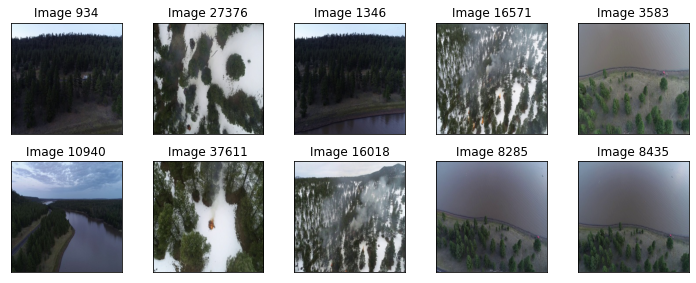

In [46]:
## Explore random sampling of 10 images
show_random_sampling(train_img_array)

At this high level, we can see that the images are taken in a variety of environments - both snow-covered and temperate forests, as well as lakeside. Notice the small size of the fires, which will be good for our early detection purposes (want to detect before they grow out of control).

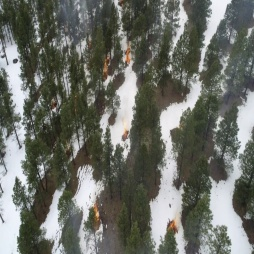

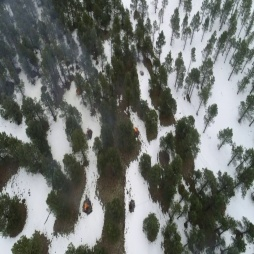

In [33]:
## Explore TRUE labels in Train dataset
train_fire_subset = train_df[train_df.label == "Fire"]

nofire_sample_1 = show_image(train_fire_subset.iloc[1000]["file_path"])
nofire_sample_2 = show_image(train_fire_subset.iloc[10000]["file_path"])

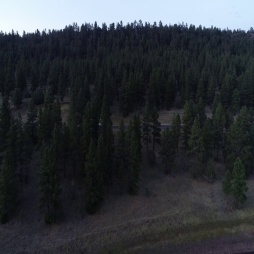

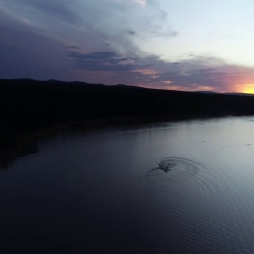

In [34]:
## Explore FALSE Labels in Train dataset
train_no_fire_subset = train_df[train_df.label == "No_Fire"]

nofire_sample_1 = show_image(train_no_fire_subset.iloc[1000]["file_path"])
nofire_sample_2 = show_image(train_no_fire_subset.iloc[10000]["file_path"])

And focusing in on the "No_Fire" part of the dataset, we again can note the robustness of the dataset. The image of the forest and lake at twilight means that our model will be better able to detect fires when recieving aerial footage from low-light hours (twilight or dawn).

### Examine Image Sizing (Graphically)

Next, we want to double-check that the size of the images is standardized. If it is not, we will need to do additional pre-processing to ensure consistency.

In [35]:
## TRAINING: Check height, width, and channels
print("TRAINING DATASET Unique Values:")
print("Pixel Height:", train_df["pixel_height"].unique())
print("Pixel Width:", train_df["pixel_width"].unique())
print("Image Channels:", train_df["image_channels"].unique())
print()

## TEST: Check height, width, and channels
print("TEST DATASET Unique Values:")
print("Pixel Height:", test_df["pixel_height"].unique())
print("Pixel Width:", test_df["pixel_width"].unique())
print("Image Channels:", test_df["image_channels"].unique())

TRAINING DATASET Unique Values:
Pixel Height: [254]
Pixel Width: [254]
Image Channels: [3]

TEST DATASET Unique Values:
Pixel Height: [254]
Pixel Width: [254]
Image Channels: [3]


In [36]:
## TRAINING: Graphing height against width
sizes = train_df.groupby(['pixel_height', 'pixel_width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='pixel_height', y='pixel_width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(line_alpha=1, fill_alpha=0.3)

:Scatter   [pixel_height]   (pixel_width,count)

In [37]:
## TEST: Graphing height against width
sizes = test_df.groupby(['pixel_height', 'pixel_width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='pixel_height', y='pixel_width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(line_alpha=1, fill_alpha=0.3)

:Scatter   [pixel_height]   (pixel_width,count)

We can see that, both from the graph and the earlier distinct counts, the training and test datasets are standard in terms of pixel width and height. So, we can proceed without having to worry about image resizing.

### Examine Image Label Distribution

Next, we will examine the distribution of the labels in the training and test datasets. The purpose here is to understand whether we will need to consider imbalance of classes when modeling.

In [38]:
#TRAIN: Examine label values
train_df["label"].value_counts()

Fire       25018
No_Fire    14357
Name: label, dtype: int64

In [39]:
#TEST: Examine label values
test_df["label"].value_counts()

Fire       5137
No_Fire    3480
Name: label, dtype: int64

The initial view of the value counts for training and test show us a relatively balanced dataset. That said, let's take a look graphically via bar charts (counts) and pie charts (percentages) to get a better visual understanding.

<AxesSubplot:title={'center':'Test Dataset: Label Counts'}, xlabel='Label', ylabel='Count'>

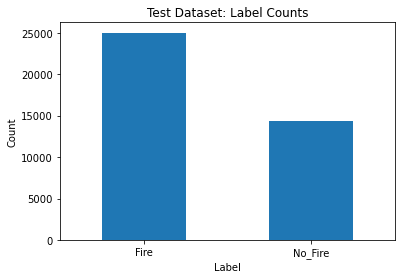

In [40]:
#TRAIN: Explore labels graphically
train_df["label"].value_counts().plot(kind='bar', xlabel = "Label", ylabel = "Count", 
                                      rot=0, title = "Test Dataset: Label Counts")

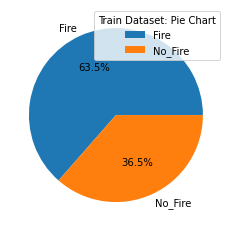

In [41]:
plt.pie(train_df["label"].value_counts(), labels = ["Fire", "No_Fire"], autopct='%1.1f%%')
plt.legend(title = "Train Dataset: Pie Chart")
plt.show() 

We see that roughly 64% of the training datset contains "Fire" images. This does not even rise to the [70/30 ratio that some have used for datasets](https://www.linkedin.com/pulse/imbalanced-data-sets-ashish-kumar/?trk=public_profile_article_view). So, we can proceed without need to consider balancing via class weight / SMOTE / etc.

<AxesSubplot:title={'center':'Test Dataset: Label Counts'}, xlabel='Label', ylabel='Count'>

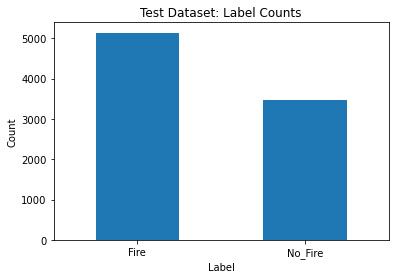

In [42]:
#TEST: Explore labels graphically
test_df["label"].value_counts().plot(kind='bar', xlabel = "Label", ylabel = "Count", 
                                      rot=0, title = "Test Dataset: Label Counts")

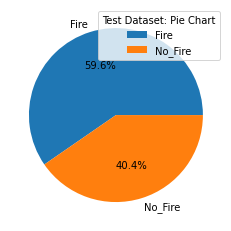

In [43]:
plt.pie(test_df["label"].value_counts(), labels = ["Fire", "No_Fire"], autopct='%1.1f%%')
plt.legend(title = "Test Dataset: Pie Chart")
plt.show() 

Similarly, the test dataset is relatively balanced with a roughly 60/40 split of "Fire" vs. "No_Fire".

### Examine Pixel Data (RGB channels) Overall, by Label

First, we will start by defining a graphing function for our pixel values that can be used throughout this section.

In [51]:
# Create a graphing function for a histogram of red/blue/green channel values
def plot_channel_values(title, image_array, channel, color):
    plt.hist(image_array[:,:,channel].ravel(), bins=256, color = color)
    plt.title(title)
    plt.xlabel(color + ' intensity')
    plt.ylabel('Frequency')
    plt.show()

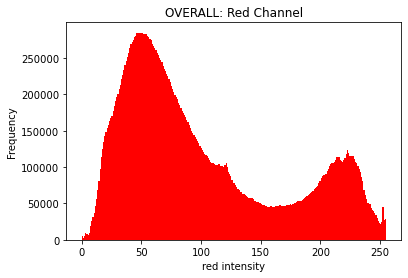

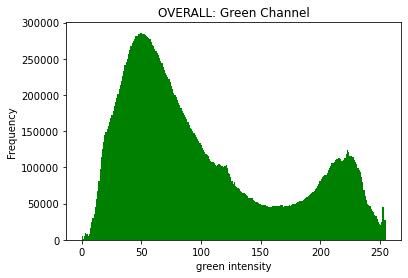

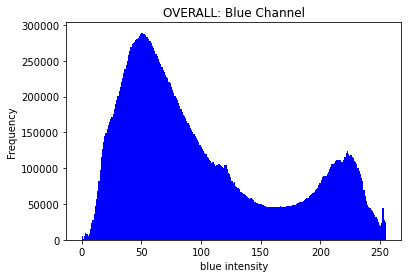

In [52]:
# OVERALL: Red Channel
plot_channel_values("OVERALL: Red Channel", train_img_array, 0, 'red')

# OVERALL: Green Channel
plot_channel_values("OVERALL: Green Channel", train_img_array, 1, 'green')

# OVERALL: Blue Channel
plot_channel_values("OVERALL: Blue Channel", train_img_array, 2, 'blue')

Next, we will turn our attention to label-specific channels to explore whether "Fire" label images have a higher red intensity than "No_Fire".

In [8]:
## By label: TO DO!

### Compute "Mean Image"

In [9]:
## Overall: TO DO!

In [ ]:
## By label: TO DO!